<div class="alert alert-block alert-success">
    <b><center>CNN Basic Examples</center></b>
    <b><center>Learning From Image File With ImageDataGenerator</center></b>
</div>

# Configure Learning Environment

In [1]:
# !pip install git+https://github.com/nockchun/rspy --force
# !pip install mybatis_mapper2sql
import rspy as rsp
rsp.setSystemWarning(off=True)
rsp.fixMemoryProblem()

1 Physical GPUs, 1 Logical GPUs


In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, datasets, preprocessing, utils

In [3]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import pandas as pd
import PIL

In [4]:
np.set_printoptions(linewidth=200, precision=2)
tf.__version__

'2.2.0'

# Download Flowers Dataset
This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# dataset_url = "file:///home/rsnet/.keras/datasets/flower_photos.tgz"
data_dir = utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [6]:
list(data_dir.glob("*"))

[PosixPath('/home/rsnet/.keras/datasets/flower_photos/roses'),
 PosixPath('/home/rsnet/.keras/datasets/flower_photos/tulips'),
 PosixPath('/home/rsnet/.keras/datasets/flower_photos/LICENSE.txt'),
 PosixPath('/home/rsnet/.keras/datasets/flower_photos/sunflowers'),
 PosixPath('/home/rsnet/.keras/datasets/flower_photos/daisy'),
 PosixPath('/home/rsnet/.keras/datasets/flower_photos/dandelion')]

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [8]:
category_flower = ["roses", "tulips", "sunflowers", "daisy", "dandelion"]

@interact(category=category_flower)
def preview(category):
    flowers = list(data_dir.glob(f"{category}/*.jpg"))
    print(f"size of flowers: {len(flowers)}")
    
    @interact(idx=(0, len(flowers)-1))
    def showFlower(idx):
        display(PIL.Image.open(flowers[idx]))

interactive(children=(Dropdown(description='category', options=('roses', 'tulips', 'sunflowers', 'daisy', 'dan…

# Prepare Learning Data

Load using keras.preprocessing
> Let's load these images off disk using the helpful image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the load images tutorial.

In [9]:
batch_size = 32
img_height = 128
img_width = 128
num_classes = 5

In [10]:
# create a data generator for to load and iterate training dataset
gen = preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.2,
    fill_mode="constant"
)

In [11]:
train_ds = gen.flow_from_directory(
    directory=data_dir,
    target_size=(img_height, img_width), 
    class_mode='categorical',
    subset="training",
    batch_size=32,
    shuffle=True,
    seed=123
)

Found 2939 images belonging to 5 classes.


In [12]:
valid_ds = gen.flow_from_directory(
    directory=data_dir,
    target_size=(img_height, img_width), 
    class_mode='categorical',
    subset="validation",
    batch_size=32,
    shuffle=True,
    seed=123
)

Found 731 images belonging to 5 classes.


In [13]:
sample_data, sample_label = train_ds.next()

In [14]:
sample_data.shape, sample_label.shape

((32, 128, 128, 3), (32, 5))

In [15]:
@interact(idx=(0, sample_data.shape[0]-1, 1))
def showSample(idx):
    plt.imshow(sample_data[idx])

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

# Create Model

In [16]:
# Normalize pixel values to be between 0 and 1
# train_datas, test_datas = train_datas / 255, test_datas / 255

The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument input_shape to our first layer.

In [17]:
inputs = layers.Input(shape=(img_height, img_width, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

In [18]:
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

In [19]:
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

In [20]:
x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes)(x)

In [21]:
model = models.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 32) 896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 124, 124, 64) 18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 41, 41, 64)   0           conv2d_1[0][0]                   
_________________________________________________________________________________________

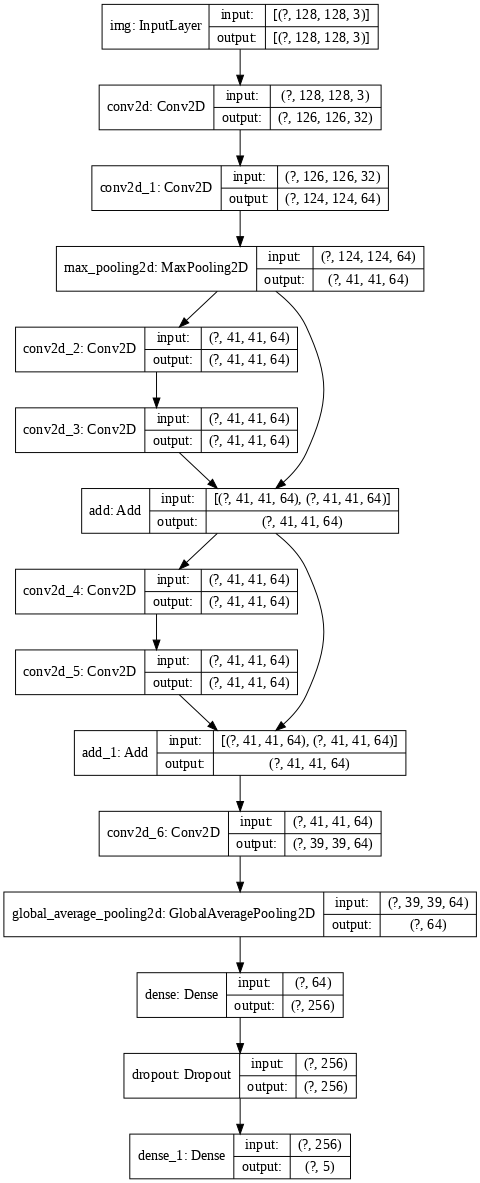

In [22]:
utils.plot_model(model, "intermediate/model.png", True, dpi=70)

In [23]:
model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(),
    metrics=["accuracy"],
)

In [24]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=20
)

Epoch 1/20
92/92 [==============================] - 35s 384ms/step - loss: 1.5036 - accuracy: 0.3086 - val_loss: 1.4187 - val_accuracy: 0.3680
Epoch 2/20
92/92 [==============================] - 18s 201ms/step - loss: 1.2765 - accuracy: 0.4457 - val_loss: 1.2823 - val_accuracy: 0.4268
Epoch 3/20
92/92 [==============================] - 19s 205ms/step - loss: 1.1747 - accuracy: 0.4886 - val_loss: 1.1615 - val_accuracy: 0.4733
Epoch 4/20
92/92 [==============================] - 19s 205ms/step - loss: 1.0754 - accuracy: 0.5311 - val_loss: 1.2379 - val_accuracy: 0.5021
Epoch 5/20
92/92 [==============================] - 20s 212ms/step - loss: 1.0435 - accuracy: 0.5675 - val_loss: 1.0269 - val_accuracy: 0.5636
Epoch 6/20
92/92 [==============================] - 19s 206ms/step - loss: 0.9986 - accuracy: 0.6070 - val_loss: 1.0413 - val_accuracy: 0.6101
Epoch 7/20
92/92 [==============================] - 19s 209ms/step - loss: 0.8964 - accuracy: 0.6465 - val_loss: 0.8909 - val_accuracy: 0.6484

In [25]:
test_scores = model.evaluate(valid_ds, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

23/23 - 4s - loss: 0.8407 - accuracy: 0.6922
Test loss: 0.8406751155853271
Test accuracy: 0.6922024488449097


<AxesSubplot:>

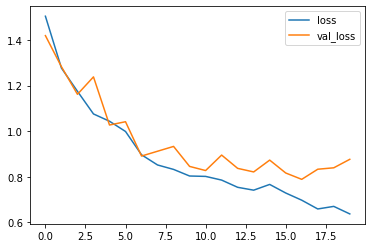

In [26]:
history_df = pd.DataFrame(history.history)
history_df[["loss", "val_loss"]].plot()

<AxesSubplot:>

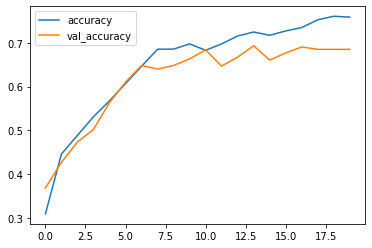

In [27]:
history_df[["accuracy", "val_accuracy"]].plot()